In [1]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')
# Importing Pandas and NumPy
import pandas as pd, numpy as np

In [2]:
# Defining the environment variables 

import os
import sys
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

In [3]:
 #Importing the SparkSession library

from pyspark.sql import SparkSession


# Creating the SparkSession object

spark = SparkSession.builder \
                    .appName('metrics')\
                    .getOrCreate()

In [4]:
spark

In [6]:
# Read the data from the result data frame you created in the model. 

#df_result = spark.read.parquet("s3n://mynithbuck/logistic/credit_card_details.parquet")

df_result = spark.read.parquet("credit_card_details.parquet")

In [7]:
df_result.show(5)

+----------+---------------+-----------------+-------------------+-----------+------------+------------------+----------------+-------------------+------------+---+----------------+--------------+-------------------+--------------+---------------------+--------------------+-------------------+----------------------+----------------------+-------------------------+-------------+-----------------+-----------------------+-----------------+-------------------------+-------------------+----------------------+------------------------+----------------------+------------------+--------------------+--------------------+--------------------+----------+
|FLAG_PHONE|FLAG_WORK_PHONE|NAME_HOUSING_TYPE|NAME_EDUCATION_TYPE|CODE_GENDER|CNT_CHILDREN|NAME_FAMILY_STATUS|NAME_INCOME_TYPE|OCCUPATION_TYPE_NEW|Months_delay|  y|FLAG_OWN_CAR_NEW|FLAG_EMAIL_NEW|CNT_FAM_MEMBERS_NEW|CODE_GENDER_ix|NAME_FAMILY_STATUS_ix|NAME_HOUSING_TYPE_ix|NAME_INCOME_TYPE_ix|NAME_EDUCATION_TYPE_ix|OCCUPATION_TYPE_NEW_ix|OCCUPATIO

In [8]:
df = df_result.select("y","probability","prediction")

In [9]:
df.collect()[5]

Row(y=0, probability=DenseVector([0.9925, 0.0075]), prediction=0.0)

In [10]:
# the probability is a dense vector column. 
# You will have to find a way to access the value of the probability referring to the positive class. 
# create a function to access the probability of the positive class form the 'probability' column


from pyspark.sql.functions import udf, when
from pyspark.sql.types import FloatType

element_extrac=udf(lambda v:float(v[1]),FloatType())

In [49]:
# create a list of all the thresholds you want to check the metrics for. 

result_list = []       # to store the values of precision and recall
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65]
#threshold_list

In [50]:
# Now you have the probabilities, your task is to add a class column. 
# To create this column, compare the probabilities with the threshold and decide the class. 
# You can make a loop which will repeat the same action for different thresholds
# Use the filter and count functions to find the true positives, false positives, false negatives. (inside the loop)
# Using these values, find the precision and recall for different thresholds. (inside the loop)


for i in threshold_list:
    test_pred = df.withColumn('label_p',when(element_extrac(df["probability"]) >= i, 1).otherwise(0))
    TP = test_pred.filter("y==1 AND label_p==1").count()
    FP = test_pred.filter("y==0 AND label_p==1").count()
    FN = test_pred.filter("y==1 AND label_p==0").count()
    TN = test_pred.filter("y==0 AND label_p==0").count()    
    recall = (TP/(TP+FN))
    presession = ((TP/(TP+FP)))
    list1 = []
    list1.append(i)
    list1.append(presession)
    list1.append(recall)
    list1.append(TP)
    list1.append(TN)
    list1.append(FP)
    list1.append(FN)
    result_list.append(list1)

In [51]:
result_list

[[0.05, 0.03333333333333333, 0.037037037037037035, 1, 10940, 29, 26],
 [0.1, 0.05263157894736842, 0.037037037037037035, 1, 10951, 18, 26],
 [0.15, 0.1, 0.037037037037037035, 1, 10960, 9, 26],
 [0.2, 0.1111111111111111, 0.037037037037037035, 1, 10961, 8, 26],
 [0.25, 0.125, 0.037037037037037035, 1, 10962, 7, 26],
 [0.3, 0.14285714285714285, 0.037037037037037035, 1, 10963, 6, 26],
 [0.35, 0.16666666666666666, 0.037037037037037035, 1, 10964, 5, 26],
 [0.4, 0.25, 0.037037037037037035, 1, 10966, 3, 26],
 [0.45, 0.5, 0.037037037037037035, 1, 10968, 1, 26],
 [0.5, 0.5, 0.037037037037037035, 1, 10968, 1, 26],
 [0.55, 1.0, 0.037037037037037035, 1, 10969, 0, 26],
 [0.6, 1.0, 0.037037037037037035, 1, 10969, 0, 26],
 [0.65, 1.0, 0.037037037037037035, 1, 10969, 0, 26]]

In [52]:
# Create a panadas datafarme for the list of the output. 

# create a schema for the dataframes 
from pyspark.sql.types import *

schema = StructType([StructField('threshold', FloatType(), True),
                      StructField('precision', FloatType(), True),
                      StructField('recall', FloatType(), True),
                      StructField('TP', IntegerType(), True),
                      StructField('TN', IntegerType(), True),
                      StructField('FP', IntegerType(), True),
                      StructField('FN', IntegerType(), True)])


# create a rdd from the list
rdd = spark.sparkContext.parallelize(result_list)


# create a spark dataframe form rdd
thresh_df = spark.createDataFrame(rdd,schema)

# create pandas dataframe form the spark dataframe 
pandas_df = thresh_df.toPandas()

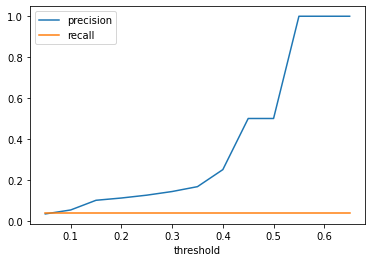

In [53]:
# import matplot lib 
import matplotlib.pyplot as plt

pandas_df.plot.line(x='threshold', y=['precision','recall'])
plt.show()

In [54]:
total_number = df.count()                  # count the total number of readings
positives = df.filter("y==1").count()      # count the total number of actual positives
negatives = df.filter("y==0").count()      # count the total number of actual negatives

In [55]:
final_df = thresh_df

In [56]:
from pyspark.sql.functions import lit

# add columns to represent the total number of readings and total number of positives. 
final_df = final_df.withColumn('total',lit(total_number))
final_df = final_df.withColumn('actual_positives',lit(positives))

# add a column with total number pf predictions for each threshold
final_df = final_df.withColumn('predicted_positives',final_df['TP']+final_df['FP'])
final_df = final_df.withColumn('predicted_negatives',final_df['TN']+final_df['TP'])

In [57]:
from pyspark.sql.functions import format_number

final_df.select(final_df['threshold'],
                format_number(final_df['precision'],3).alias('precision'),
                format_number(final_df['recall'],3).alias('recall'),
                'total',
                'actual_positives',
                'predicted_positives',
                'predicted_negatives',
                          
               ).show()

+---------+---------+------+-----+----------------+-------------------+-------------------+
|threshold|precision|recall|total|actual_positives|predicted_positives|predicted_negatives|
+---------+---------+------+-----+----------------+-------------------+-------------------+
|     0.05|    0.033| 0.037|10996|              27|                 30|              10941|
|      0.1|    0.053| 0.037|10996|              27|                 19|              10952|
|     0.15|    0.100| 0.037|10996|              27|                 10|              10961|
|      0.2|    0.111| 0.037|10996|              27|                  9|              10962|
|     0.25|    0.125| 0.037|10996|              27|                  8|              10963|
|      0.3|    0.143| 0.037|10996|              27|                  7|              10964|
|     0.35|    0.167| 0.037|10996|              27|                  6|              10965|
|      0.4|    0.250| 0.037|10996|              27|                  4|         

In [58]:
df_panda = df.toPandas()

In [59]:
df_panda.head(5)

,y,probability,prediction
0,0,"[0.9938525198254733, 0.00614748017452675]",0.0
1,0,"[0.9938525198254733, 0.00614748017452675]",0.0
2,0,"[0.9964697473774089, 0.0035302526225910076]",0.0
3,0,"[0.9989191669596404, 0.0010808330403595063]",0.0
4,0,"[0.9992565737521846, 0.0007434262478154521]",0.0


In [60]:
from sklearn import metrics

In [61]:
# Confusion matrix 
confusion = metrics.confusion_matrix(df_panda.y, df_panda.prediction )
print(confusion)

[[10968     1]
 [   26     1]]


In [59]:
# Predicted     del    not del
# Actual
# del           10968     1
# notdel         26       1

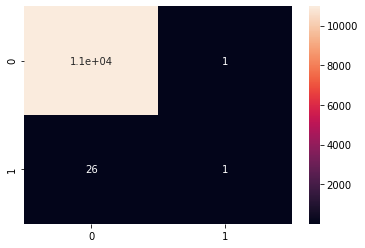

In [62]:
import seaborn as sns
sns.heatmap(confusion, annot=True)
plt.show()

In [63]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(df_panda.y, df_panda.prediction))

0.997544561658785


In [64]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [65]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.037037037037037035

In [66]:
# Let us calculate specificity
TN / float(TN+FP)

0.9999088339866897

In [30]:
# Calculate false postive rate - predicting deliquent when customer does not have deliquent
print(FP/ float(TN+FP))

9.116601331023795e-05


In [67]:
# positive predictive value 
print (TP / float(TP+FP))

0.5


In [68]:
# Negative predictive value
print (TN / float(TN+ FN))


0.9976350736765508


In [69]:
from sklearn.metrics import precision_score, recall_score
recall_score(df_panda.y, df_panda.prediction)

0.037037037037037035

In [33]:
 from sklearn.metrics import f1_score
    
    #calculating the F1_score

In [70]:
df_panda.prediction.value_counts()

0.0    10994
1.0        2
Name: prediction, dtype: int64

In [71]:
f1_score(df_panda.y, df_panda.prediction, average = None)

array([0.99877066, 0.06896552])

In [72]:
f1_score(df_panda.y, df_panda.prediction, average = 'weighted')

0.9964875805491719

In [73]:
f1_score(df_panda.y, df_panda.prediction, average = 'micro')

0.997544561658785